In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/filmdeathcounts.csv', sep=',')

In [3]:
df.head()

,Film,Year,Body_Count,MPAA_Rating,Genre,Director,Length_Minutes,IMDB_Rating
0,24 Hour Party People,2002,7,R,Biography|Comedy|Drama|Music,Michael Winterbottom,117,7.3
1,28 Days Later,2002,53,R,Horror|Sci-Fi|Thriller,Danny Boyle,113,7.6
2,28 Weeks Later,2007,212,R,Horror|Sci-Fi|Thriller,Juan Carlos Fresnadillo,100,7.0
3,30 Days of Night,2007,67,R,Horror|Thriller,David Slade,113,6.6
4,300,2007,600,R,Action|Fantasy|History|War,Zack Snyder,117,7.7


In [4]:
# Homework 2, I
# Choost 3-6 features, explain
# Apply k-means at k=5, k=9
# In both cases take 10 or more random inits, choose the best over the K-means criterion
# Homework 2, II
# Take one partition
# Compare one of the features between two clusters using bootstrap
# Take a feature, find 95% confidence interval for grand mean using bootstrap
# Take a cluster, compare the grand mean with the within-cluster mean for the feature by using bootstrap
# Note: each application of bootstrap sohuld be done inboth pivotal and non-pivotal versions

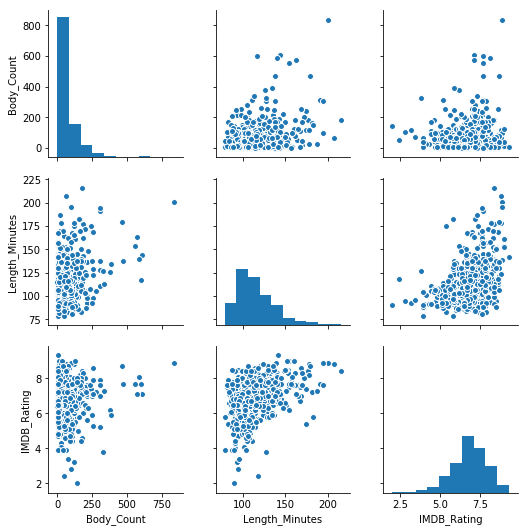

In [15]:
# K-means
features = ['Body_Count', 'Length_Minutes', 'IMDB_Rating']
task_df = pd.DataFrame(df[features])
sns.pairplot(task_df)

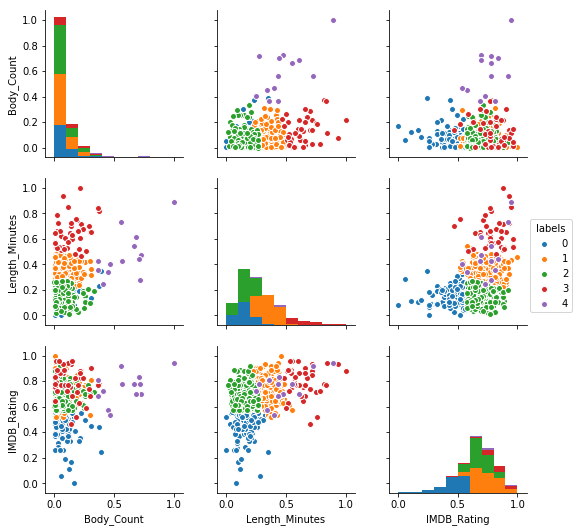

In [32]:
scaler = MinMaxScaler()
task_df_scaled = pd.DataFrame(scaler.fit_transform(task_df), columns=features)
kmeans = KMeans(n_clusters=5)
kmeans.fit(task_df_scaled)
task_df_scaled['labels'] = pd.Series(kmeans.predict(task_df_scaled))
sns.pairplot(task_df_scaled, hue='labels', vars=features)